### Data Preparation

The begining chunk of this code is meant to import the data from Google Drive. This could be changed to import from local .csv files as well. Once the data is imported we clean the data and create a vanillic and pca dataframe. These are the dataframes used for training and testing our generative model.

In [ ]:
# this code is required to mount the google drive to the notebook so we can access the data files and output folders

from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob 
import numpy as np
import random
import sys
from numpy.random import randint
from numpy.random import randn
import pickle
from IPython import display
import scipy.stats as stat
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import pickle

!pip install tensorflow==2.4.1

import tensorflow as tf

import time

from tensorflow.keras import backend as K

In [ ]:
dataroot = "drive/My Drive/College/Research/Datasets/ML Data/cumulativedata/"

df_vanilla = pd.DataFrame()
df_pca = pd.DataFrame()

# creating the initial path needed to find the csv file that contains our data
all_files = glob.glob(os.path.join(dataroot, "*.csv"))     

# loop that will read the csv as a dataframe, clean the dataframe and extract the concentration values
for f in all_files:

  df_temp = pd.read_csv(f)

  if('VA' in f):
    
    df_vanilla = df_vanilla.append(df_temp, ignore_index = True)

  if('pCA' in f):

    df_pca = df_pca.append(df_temp, ignore_index = True)

final_vanilla = df_vanilla.drop(columns=['Unnamed: 0', 'acid type', 'electrode number', 'quantity run number', 'electrode run number'])
final_vanilla = final_vanilla.iloc[:, 0:201]
final_pca = df_pca.drop(columns=['Unnamed: 0', 'acid type', 'electrode number', 'quantity run number', 'electrode run number'])
final_pca = final_pca.iloc[:, 0:201]

### Model Architecture

Here we create our Variational Autoencoder. The architecture is described in the paper. We created this as a class that is built from the funcitonal tensorflow model api. 

In [ ]:
class VAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    current_input = tf.keras.Input(shape=(200, 1), name = 'current_input') # this is 1 because we only need to pass one current input, not an array

    current_branch = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(current_input)
    current_branch_1 = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(current_branch)
    current_branch_2 = tf.keras.layers.Dropout(0.5)(current_branch_1)
    current_branch_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(current_branch_2)
    current_branch_4 = tf.keras.layers.Flatten()(current_branch_3)

    concentration_input = tf.keras.Input(shape=(1, ), name = 'concentration_input') # we only need to pass 1 concentration value to judge

    concentration_branch = tf.keras.layers.Dense(16, activation = 'relu', name = 'concentration_branch')(concentration_input) # this layer can be expanded on later for further modeling
    concentration_branch_1 = tf.keras.layers.Dense(32, activation = 'relu')(concentration_branch)

    x = tf.keras.layers.Concatenate(axis=1)([current_branch_4, concentration_branch_1])

    output = tf.keras.layers.Dense(latent_dim + latent_dim)(x)

    self.encoder = tf.keras.Model([current_input, concentration_input], output, name = "encoder")

    self.encoder.summary()

    latent_input = tf.keras.Input(shape=(latent_dim, 1), name = 'latent_input') # this is 1 because we only need to pass one current input, not an array

    latent_branch = tf.keras.layers.Conv1DTranspose(filters = 32, kernel_size = 3, activation = 'relu')(latent_input) # this layer can be expanded on later for further modeling
    latent_branch_1 = tf.keras.layers.Conv1DTranspose(filters = 16, kernel_size = 3, activation = 'relu')(latent_branch)
    latent_branch_2 = tf.keras.layers.Conv1DTranspose(filters = 1, kernel_size = 3, activation = 'relu')(latent_branch_1)
    latent_branch_3 = tf.keras.layers.Flatten()(latent_branch_2)

    decoder_concentration_input = tf.keras.Input(shape=(1, ), name = 'decoder_concentration_input') # we only need to pass 1 concentration value to judge

    decoder_concentration_branch = tf.keras.layers.Dense(16, activation = 'relu', name = 'decoder_concentration_branch')(decoder_concentration_input) # this layer can be expanded on later for further modeling
    decoder_concentration_branch_1 = tf.keras.layers.Dense(32, activation = 'relu')(decoder_concentration_branch)

    y = tf.keras.layers.Concatenate(axis=1)([latent_branch_3, decoder_concentration_branch_1])

    output = tf.keras.layers.Dense(200)(y)

    self.decoder = tf.keras.Model([latent_input, decoder_concentration_input], output, name = "decoder")

    self.decoder.summary()

# generates a sample from the decoder
  @tf.function
  def sample(self, concentration, z):

    return self.decode(z, concentration, apply_sigmoid=True)
# encodes a sample
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
# performs the reparameterization trick described here: https://www.tensorflow.org/tutorials/generative/cvae
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
# decodes a sample and returns an array of logits
  def decode(self, z, concentration, apply_sigmoid=False):
    logits = self.decoder([z, concentration])
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### Training and Loss Functions

These functions were created to train and keep track of the loss of our model. There are also scaling functions that do internal scaling and inverse scaling. 

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# https://www.tf.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

@tf.function
def scale(tensor, min_concentration_tensor, max_concentration_tensor):

  final_tensor = tf.math.divide(
   tf.subtract(
      tensor, 
      min_concentration_tensor
   ), 
   tf.subtract(
      max_concentration_tensor, 
      min_concentration_tensor
   )
)
  return final_tensor

@tf.function
def inverse_scale(tensor, min_concentration_tensor, max_concentration_tensor): #multiply z by standard deviation and add mean

  final_tensor = tf.math.multiply( 
   tf.subtract(
      max_concentration_tensor, 
      min_concentration_tensor
   ),   
   tensor
)
  
  hello = tf.math.add(final_tensor, min_concentration_tensor)

  return hello

def compute_loss(model, current_tensor, concentration_value, concentration_tensor):

  max_value = max[concentration_value]

  max_tensor = tf.constant(max_value, shape=(1,200))

  min_value = min[concentration_value]

  min_tensor = tf.constant(min_value, shape=(1,200))

  scaled_current_tensor = scale(current_tensor, min_tensor, max_tensor)

  mean, logvar = model.encode([scaled_current_tensor, concentration_tensor])

  z = model.reparameterize(mean, logvar)

  x_logit = model.decode(z, concentration_tensor)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=scaled_current_tensor)  # comparing the scaled tensors
  
  logpx_z = -tf.reduce_sum(cross_ent, axis=[0,1])

  logpz = log_normal_pdf(z, 0., 0.)

  logqz_x = log_normal_pdf(z, mean, logvar)

  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def train_step(model, current_tensor, concentration_value, concentration_tensor, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, current_tensor, concentration_value, concentration_tensor)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Model Creation and Experimentation

Here we begin by creating our two models and define the latent dimensions, epochs to run, and our Adam optimizer

In [ ]:
%xmode Verbose
%matplotlib inline

latent_dim = 4
epochs = 25
tf.config.run_functions_eagerly(True)
optimizer = tf.keras.optimizers.Adam(1e-4)

vanilla_model = VAE(latent_dim)
pca_model = VAE(latent_dim)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
current_input (InputLayer)      [(None, 200, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 198, 16)      64          current_input[0][0]              
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 196, 16)      784         conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 196, 16)      0           conv1d_1[0][0]                   
____________________________________________________________________________________________

### Variable Definitions

There are 4 different constant arrays that we need to define. The concentration array holds all the possible concentrations in our training set. The max and min dictionaries allow us to keep track of the maximium and minimum values for each concentration for scaling. The elbo array allows us to track the progress of our training.

In [ ]:
concentration_array = [0.0195, 0.039, 0.078, 0.156, 0.3125, 0.625, 0.5, 0.25, 0.1, 1.25, 2.5, 5.0, 0.023, 0.09375, 0.1875, 0.375, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.3, 2.7, 3.0, 10.0, 20.0, 30.0, 50.0, 75.0, 25.0]

max = {}
min = {}
elbo_array = {}

### Model Training

We trained the model on each concentration for that respective dataset. We needed to keep track of the error (ELBO) as well as the maximum and minimum values per concentration for scaling. We ran this train_model function 3 total times for each model.

In [ ]:
def train_model(model, final_dataset):

  for concentration in concentration_array:

    final = final_dataset.loc[final_dataset['concentration (micro)'] == concentration]

    if final.empty:
      print('no examples for ' + str(concentration))

    else:

      final = final.drop(columns = ['concentration (micro)'])

      temp_max = final.max().to_numpy()
      temp_min = final.min().to_numpy()

      biggest = np.amax(temp_max)
      smallest = np.amin(temp_min)

      max[concentration] = biggest.astype('float32')
      min[concentration] = smallest.astype('float32')

      final_concentration = tf.reshape(concentration, [1, 1])   

      elbo_temp = []

      for epoch in range(1, epochs + 1):
        loss = tf.keras.metrics.Mean()
        i = 0
        while i < len(final): # arbitrary values 

          seq = final.iloc[i].to_numpy() 

          seq = seq.astype(np.float32)

          current_loop = np.reshape(seq, [1, 200])

          train_step(model, current_loop, concentration, final_concentration, optimizer)

          loss(compute_loss(model, current_loop, concentration, final_concentration))
        
          elbo = -loss.result()

          i = i+1

        elbo_temp.append(elbo.numpy())
        
        print('Epoch: {}, ELBO: {} for {} uM'
            .format(epoch, elbo, concentration))

      elbo_array[concentration] = elbo_temp

  return elbo_array 

In [ ]:
i = 0
while i <3:  

  vanilla_elbo = train_model(vanilla_model, final_vanilla)
  pca_elbo = train_model(pca_model, final_pca)

  i = i+1

no examples for 0.0195
no examples for 0.039
no examples for 0.078
no examples for 0.156
no examples for 0.3125
no examples for 0.625
Epoch: 1, ELBO: -138.75265502929688 for 0.5 uM
Epoch: 2, ELBO: -138.44688415527344 for 0.5 uM
Epoch: 3, ELBO: -138.09710693359375 for 0.5 uM
Epoch: 4, ELBO: -137.6656951904297 for 0.5 uM
Epoch: 5, ELBO: -137.24423217773438 for 0.5 uM
Epoch: 6, ELBO: -136.82723999023438 for 0.5 uM
Epoch: 7, ELBO: -136.26588439941406 for 0.5 uM
Epoch: 8, ELBO: -135.60031127929688 for 0.5 uM
Epoch: 9, ELBO: -134.9176483154297 for 0.5 uM
Epoch: 10, ELBO: -134.18438720703125 for 0.5 uM
Epoch: 11, ELBO: -133.38209533691406 for 0.5 uM
Epoch: 12, ELBO: -132.19650268554688 for 0.5 uM
Epoch: 13, ELBO: -130.77151489257812 for 0.5 uM
Epoch: 14, ELBO: -129.96987915039062 for 0.5 uM
Epoch: 15, ELBO: -127.93778991699219 for 0.5 uM
Epoch: 16, ELBO: -127.0489273071289 for 0.5 uM
Epoch: 17, ELBO: -126.05621337890625 for 0.5 uM
Epoch: 18, ELBO: -123.56636810302734 for 0.5 uM
Epoch: 19, ELB

### Data Visualization

The following functions were made to visualize the elbo as well as compare real and generated curves. 

In [ ]:
def visualize_elbo(concentration, elbo_array):

  if concentration in elbo_array:
    data = elbo_array[concentration]

    plt.plot(data, color = 'goldenrod', linewidth = 2.0)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(str(concentration) + " mM Training Progression")

    plt.figure(figsize=(20,10))

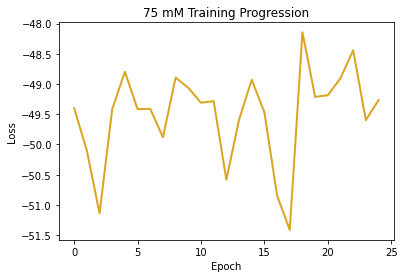

<Figure size 1440x720 with 0 Axes>

In [ ]:
visualize_elbo(75, pca_elbo)

This cell is just for testing individual runs for each concentration

In [ ]:
 def create(concentration, model):

  random_vector_for_generation = tf.random.normal(
      shape=[1, latent_dim])
  
  max_value = max[concentration]

  max_tensor = tf.constant(max_value, shape=[1,200])

  min_value = min[concentration]

  min_tensor = tf.constant(min_value, shape=[1,200])

  x = tf.reshape(random_vector_for_generation, [1, latent_dim])

  sample = model.sample(tf.reshape(concentration, [1, 1]) , x)

  inverted = inverse_scale(sample, min_tensor, max_tensor)

  return inverted

In [ ]:
def compare(concentration, model, final_dataset):

  generated = create(concentration, model).numpy()
  generated_plot = generated.ravel()

  data = final_dataset.loc[final_dataset['concentration (micro)'] == concentration]
  real = data.drop(columns = ['concentration (micro)'])
  real_seq = real.iloc[0].to_numpy()
  real_seq_plot = real_seq.astype(np.float32)

  plt.plot(real_seq_plot, label = 'real sample', linewidth = 2.0, color = 'mediumblue')
  plt.plot(generated_plot, label = 'generated sample', linewidth = 2.0, color="goldenrod")

  plt.legend(loc="upper right")
  plt.title(str(concentration) + " mM Comparison (Vanillic)")
  plt.figure(figsize=(20,10))

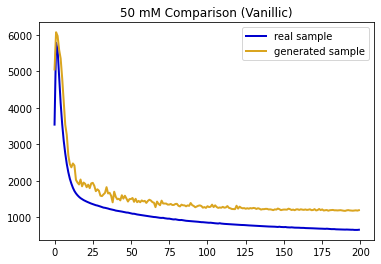

<Figure size 1440x720 with 0 Axes>

In [ ]:
compare(50, vanilla_model, final_vanilla)

### Data Generation

We created differing amounts of data for each type of acid. We simply looped through the create function and created diffring numbers of samples. These were then exported as csv files to be used with the predictive model. 

In [ ]:
generated_vanilla_25 = pd.DataFrame()
generated_pca_25 = pd.DataFrame()

generated_vanilla_50 = pd.DataFrame()
generated_pca_50 = pd.DataFrame()

generated_vanilla_100 = pd.DataFrame()
generated_pca_100 = pd.DataFrame()

generated_vanilla_250 = pd.DataFrame()
generated_pca_250 = pd.DataFrame()

generated_vanilla_500 = pd.DataFrame()
generated_pca_500 = pd.DataFrame()

generated_vanilla_1000 = pd.DataFrame()
generated_pca_1000 = pd.DataFrame()

In [ ]:
vanilla_concentration_array = {0.1, 0.5, 5, 1, 0.25, 20, 10, 30, 50, 25, 75}
pca_concentration_array = {1, 5, 75, 10, 20, 50, 25, 30}

In [ ]:
for concentration in vanilla_concentration_array:

  i = 0
  while i < 25:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_25 = generated_vanilla_25.append(df_temp)

    i = i+1
  
for concentration in vanilla_concentration_array:

  i = 0
  while i < 50:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_50 = generated_vanilla_50.append(df_temp)

    i = i+1

for concentration in vanilla_concentration_array:

  i = 0
  while i < 100:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_100 = generated_vanilla_100.append(df_temp)

    i = i+1

for concentration in vanilla_concentration_array:

  i = 0
  while i < 250:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_250 = generated_vanilla_250.append(df_temp)

    i = i+1

for concentration in vanilla_concentration_array:

  i = 0
  while i < 500:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_500 = generated_vanilla_500.append(df_temp)

    i = i+1

for concentration in vanilla_concentration_array:

  i = 0
  while i < 1000:

    generated = create(concentration, vanilla_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_vanilla_1000 = generated_vanilla_1000.append(df_temp)

    i = i+1

In [ ]:
for concentration in pca_concentration_array:

  i = 0
  while i < 25:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_25 = generated_pca_25.append(df_temp)

    i = i+1
  
for concentration in pca_concentration_array:

  i = 0
  while i < 50:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_50 = generated_pca_50.append(df_temp)

    i = i+1

for concentration in pca_concentration_array:

  i = 0
  while i < 100:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_100 = generated_pca_100.append(df_temp)

    i = i+1

for concentration in pca_concentration_array:

  i = 0
  while i < 250:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_250 = generated_pca_250.append(df_temp)

    i = i+1

for concentration in pca_concentration_array:

  i = 0
  while i < 500:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_500 = generated_pca_500.append(df_temp)

    i = i+1

for concentration in pca_concentration_array:

  i = 0
  while i < 1000:

    generated = create(concentration, pca_model).numpy()
    df_temp = pd.DataFrame(generated)
    df_temp.insert(loc=0, column='concentration (micro)', value=concentration)

    generated_pca_1000 = generated_pca_1000.append(df_temp)

    i = i+1

In [ ]:
generated_vanilla_25.to_csv('drive/MyDrive/generated_vanilla_25.csv')
generated_pca_25.to_csv('drive/MyDrive/generated_pca_25.csv')

generated_vanilla_50.to_csv('drive/MyDrive/generated_vanilla_50.csv')
generated_pca_50.to_csv('drive/MyDrive/generated_pca_50.csv')

generated_vanilla_100.to_csv('drive/MyDrive/generated_vanilla_100.csv')
generated_pca_100.to_csv('drive/MyDrive/generated_pca_100.csv')

generated_vanilla_250.to_csv('drive/MyDrive/generated_vanilla_250.csv')
generated_pca_250.to_csv('drive/MyDrive/generated_pca_250.csv')

generated_vanilla_500.to_csv('drive/MyDrive/generated_vanilla_500.csv')
generated_pca_500.to_csv('drive/MyDrive/generated_pca_500.csv')

generated_vanilla_1000.to_csv('drive/MyDrive/generated_vanilla_1000.csv')
generated_pca_1000.to_csv('drive/MyDrive/generated_pca_1000.csv')